[データセット](https://github.com/taku-buntu/killme_adversarial_example_with_TensorFlow-Keras/raw/master/kill_me_images/kill_me_baby_datasets.zip) をダウンロードして解凍する。


In [1]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
dataset_dirpath = 'kill_me_baby_datasets'

label_to_name = {}  # 名前とラベルの対応関係
data = []  # データ
labels = []  # ラベル

# ディレクトリから画像を読み込む。
for label, label_name in enumerate(sorted(os.listdir(dataset_dirpath))):
    label_to_name[label] = label_name
    
    for img_path in glob.glob(os.path.join(dataset_dirpath, label_name, '*.png')):
        img = cv2.imread(img_path)  # 画像を読み込む。
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC) # リサイズする。

        data.append(img)
        labels.append(label)
data = np.array(data)
labels = np.array(labels)
num_classes = len(label_to_name)  # クラス数

# データセットの情報を表示する。
for label, label_name in label_to_name.items():
    print('class name: {:<12} class id: {} number of images: {}'.format(
        label_name, label, len(data[labels==label])))

class name: agiri        class id: 0 number of images: 44
class name: botsu        class id: 1 number of images: 10
class name: others       class id: 2 number of images: 64
class name: sonya        class id: 3 number of images: 175
class name: yasuna       class id: 4 number of images: 341
class name: yasuna&agiri class id: 5 number of images: 4
class name: yasuna&sonya class id: 6 number of images: 47


In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 学習済みモデル VGG16 を構築する。
vgg16 = VGG16(include_top=False, weights='imagenet',
              classes=num_classes, input_shape=(128, 128, 3))

# 転移学習なので、VGG16 の層はすべてフリーズする。
for layer in vgg16.layers:
    layer.trainable = False

# クラス分類用の層を追加する。
x = Flatten()(vgg16.output)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
logits = Dense(num_classes)(x)
output = Activation('softmax')(logits)
model = Model(inputs=vgg16.input, outputs=output)

# 学習方法を設定する。
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [4]:
epochs = 100  # エポック数
batch_size = 32  # バッチサイズ

# 学習用のジェネレーターを作成する。
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    dataset_dirpath, target_size=model.input_shape[1:3], batch_size=batch_size)

# 学習する。
history = model.fit_generator(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                              epochs=epochs, verbose=0)

# モデルを保存する。
os.makedirs('models', exist_ok=True)
model.save(os.path.join('models', 'killme_vgg16.h5'))

Found 685 images belonging to 7 classes.


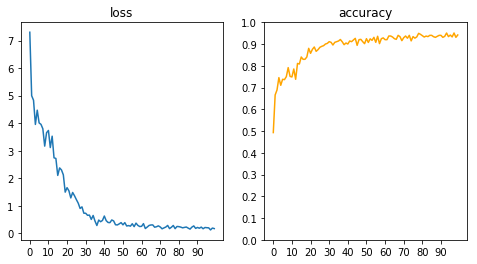

In [5]:
import matplotlib.pyplot as plt
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))

epochs = np.arange(len(history.history['loss']))

# 各エポックの誤差の推移
ax1.set_title('loss')
ax1.plot(epochs, history.history['loss'])
ax1.set_xticks(epochs[::10])

# 各エポックの精度の推移
ax2.set_title('accuracy')
ax2.plot(epochs, history.history['acc'], c='orange')
ax2.set_xticks(epochs[::10])
ax2.set_yticks(np.arange(0, 1.1, 0.1))

plt.show()

In [6]:
from sklearn.metrics import accuracy_score

# 学習精度を計算する。
pred_labels = model.predict(preprocess_input(data)).argmax(axis=-1)

accuracy = accuracy_score(labels, pred_labels)
print('train accracy: {:.2%}'.format(accuracy))  # train accracy: 98.83%

train accracy: 98.83%


In [7]:
# Adversarial Examples 用のモデルを作成する。
target_class = tf.placeholder(dtype=tf.int32)
# 損失関数
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=[target_class])
# 損失関数の入力画像に関する勾配
gradient = tf.gradients(loss, model.input)

In [8]:
def find_adversary_noise(img, label_target,
                         noise_limit=3., required_score=0.99, max_iterations=100):
    sess = tf.keras.backend.get_session()

    noise = 0  # ノイズの初期値は0にする。

    # 画像の予測ラベル
    x = preprocess_input(img)
    x = np.expand_dims(x, axis=0)
    label_source = model.predict(x).argmax()

    for i in range(max_iterations):
        # 画像にノイズを加える。
        noisy_img = img + noise

        # 画素値を [0, 255] に収まるようにクリップする。
        noisy_img = np.clip(noisy_img, a_min=0, a_max=255)

        # 予測値及び勾配を計算する。
        x = preprocess_input(noisy_img)
        x = np.expand_dims(x, axis=0)
        pred, grad = sess.run([model.output, gradient],
                               feed_dict={model.input: x, target_class: label_target})
        pred = np.squeeze(pred)  # (1, NumClasses) -> (NumClasses,)
        grad = np.squeeze(grad)  # (1, 1, Height, Width, 3) -> (Height, Width, 3)

        # ステップ数を計算する。
        grad_absmax = np.abs(grad).max()
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10
        step_size = 7 / grad_absmax

        score_source = pred[label_source]  # 元の予測ラベルの確率
        score_target = pred[label_target]  # ターゲットのラベルの確率

        # 情報を表示する。
        print('[Source] score: {0: 9.2%}, label: {1:}, name: {2}'.format(
            score_source, label_source, label_to_name[label_source]))
        print('[Target] score: {0: 9.2%}, label: {1:}, name: {2}'.format(
            score_target, label_target, label_to_name[label_target]))
        print('[Gradient] min: {0:9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}\n'.format(
            grad.min(), grad.max(), step_size))

        if score_target >= required_score:
            break

        # ノイズを更新する。
        noise -= step_size * grad
        # ノイズを [-noise_limit, noise_limit] に収まるようにクリップする。
        noise = np.clip(a=noise, a_min=-noise_limit, a_max=noise_limit)

    return noise

In [11]:
img = data[100]  # Adversarial Examples 生成に使用する画像

# ラベル4と誤判定される Adversarial Examples を生成する。
noise = find_adversary_noise(img, label_target=3)

[Source] score:   100.00%, label: 2, name: others
[Target] score:     0.00%, label: 3, name: sonya
[Gradient] min: -0.039769, max:  0.031882, stepsize:    176.02

[Source] score:   100.00%, label: 2, name: others
[Target] score:     0.00%, label: 3, name: sonya
[Gradient] min: -0.046779, max:  0.049719, stepsize:    140.79

[Source] score:   100.00%, label: 2, name: others
[Target] score:     0.00%, label: 3, name: sonya
[Gradient] min: -0.014862, max:  0.012962, stepsize:    470.99

[Source] score:    98.00%, label: 2, name: others
[Target] score:     0.00%, label: 3, name: sonya
[Gradient] min: -0.012595, max:  0.014461, stepsize:    484.07

[Source] score:    55.27%, label: 2, name: others
[Target] score:     0.05%, label: 3, name: sonya
[Gradient] min: -0.005544, max:  0.004879, stepsize:   1262.66

[Source] score:    83.10%, label: 2, name: others
[Target] score:    15.95%, label: 3, name: sonya
[Gradient] min: -0.004333, max:  0.003844, stepsize:   1615.35

[Source] score:    41.

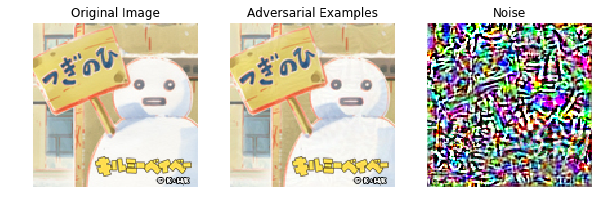

In [12]:
def array_to_img(x):
    img = 255 * (x - x.min()) / (x.max() - x.min())
    return img.astype(np.uint8)

# ノイズを付加した画像を生成する。
noisy_img = np.clip(img + noise, a_min=0, a_max=255).astype(np.uint8)

# 描画する。
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Original Image')
ax1.imshow(img)
ax1.set_axis_off()

ax2.set_title('Adversarial Examples')
ax2.imshow(noisy_img)
ax2.set_axis_off()

ax3.set_title('Noise')
ax3.imshow(array_to_img(noise))
ax3.set_axis_off()

plt.show()